##  A simple convolutional neural net for MNIST classification with data augmentation and early stopping
A model contains: 
 - batch_norm
 - dropout
 - exponentialy decaying learning rate
 
In this notebook we will train and test CNN model on the augmented data.

In [1]:
import os
import sys
import blosc
import seaborn

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

sys.path.append("..")
from my_batch import MnistBatch
from dataset import DatasetIndex, Dataset
from dataset import F, V, B
from my_batch import draw_stats, draw_digit
from mnist_model import MyMnistModel

## Load data

Let us load all data at once instead of doing this for every batch because it can all be loaded in memory.

In [2]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

with open('mnist_pics.blk', 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open('mnist_labels.blk', 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

env: CUDA_VISIBLE_DEVICES=1


## Create dataset:

In [3]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = []
lr_history = []

## Train on the original data

In [5]:
SIZE = 28
BATCH_SIZE = 100

In [6]:
ppl = (mnistset.train.p
                     .load(src=src, fmt='ndarray')
                     .init_variable('acc_history', init_on_each_run=list)
                     .init_model('static', MyMnistModel, 'MyMnistModel',
                      config={'loss': 'ce',
                     'optimizer': {'name':'GradientDescentOptimizer', 'use_locking': True},
                     'decay': {'name':'exp', 'decay_rate': 0.85, 'learning_rate': 0.001, 'decay_steps': 150, 'staircase': True},
                              'images_shape': SIZE})
                     .train_model('MyMnistModel', fetches='accuracy', feed_dict={'input_images': B('images'),
                                         'input_labels': B('labels'),
                                         'keep_prob':0.9},
                                 append_to=V('acc_history')))

In [7]:
ppl_test = (mnistset.test.p
                    .load(src=src, fmt='ndarray')
                    .init_variable('test_acc_history', init_on_each_run=list)
                    .import_model('MyMnistModel', ppl)
                    .predict_model('MyMnistModel', fetches='accuracy', feed_dict={'input_images': B('images'),
                                                                                  'input_labels': B('labels'),
                                                                                  'keep_prob':1.0},
                                   append_to=V('test_acc_history')))

In [8]:
max_accuracy = 0.0
window = 50
sum_window = 0.0
stop_condition = 0.9


In [9]:
for i in tqdm(range(1000)):
    ppl.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    ppl_test.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    current_acc = ppl.get_variable('acc_history')[-1]

    if current_acc > max_accuracy:
        max_accuracy = current_acc
    if i % 50 == 0:
        cr = sum_window / window * max_accuracy 
        sum_window = sum(ppl.get_variable('acc_history')[i - window + 1: i])
        # do early stopping
        if cr > stop_condition:
            break

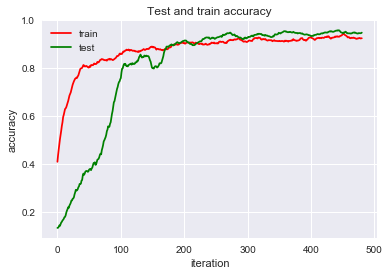

In [10]:
draw_stats([ppl.get_variable('acc_history'), ppl_test.get_variable('test_acc_history')], \
           ['train', 'test'], 'Test and train accuracy')

## Test on augmented data (shifted, rotated, scaled)

In [11]:
ppl_test_shift = (mnistset.test.p
                        .load(src=src, fmt='ndarray')
                        .shift_flattened_pic() \
                        .random_rotate(p=1, angle=(-10, 10), preserve_shape=True) \
                        .random_scale(p=1, factor=(.8, 1.2)) \
                        .init_variable('augmented_acc_history', init_on_each_run=list)
                        .import_model('MyMnistModel', ppl)
                        .predict_model('MyMnistModel', fetches='accuracy', feed_dict={'input_images': B('images'),
                                                                      'input_labels': B('labels'),
                                                                      'keep_prob':1.0},
                        append_to=V('augmented_acc_history')))

In [12]:
for i in tqdm(range(400)):
    ppl_test_shift.next_batch(100, n_epochs=None)

Predictably we see that our net badly predicts augmented data

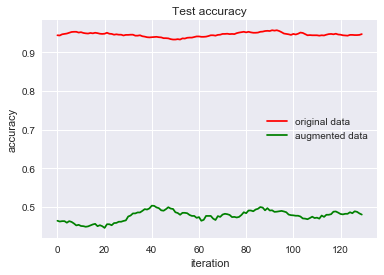

In [13]:
draw_stats([ppl_test.get_variable('test_acc_history')[-150:], \
            ppl_test_shift.get_variable('augmented_acc_history')[-150:]], \
            ['original data', 'augmented data'], 'Test accuracy')

Let's see some examples where the net makes mistakes:

In [15]:
ppl_results = (mnistset.test.pipeline() 
                            .load(src=src, fmt='ndarray')
                            .shift_flattened_pic() 
                            .random_rotate(p=1, angle=(-10, 10), preserve_shape=True) 
                            .random_scale(p=1, factor=(.8, 1.2)) 
                            .init_variable('y_predict', init_on_each_run=list)
                            .init_variable('y_true', init_on_each_run=list)
                            .init_variable('probs', init_on_each_run=list)
                            .init_variable('pics', init_on_each_run=list)
                            .import_model('MyMnistModel', ppl)
                            .predict_model('MyMnistModel', fetches=[('predicted_labels'), ('true_labels'), 
                                                                    ('predicted_prob'), ('input_images')], 
                                                           feed_dict={'input_images': B('images'),
                                                                      'input_labels': B('labels'),
                                                                      'keep_prob':1.0},
                                                           append_to=[V('y_predict'), V('y_true'), V('probs'), V('pics')]))

In [16]:
ppl_results.next_batch(100, n_epochs=None)

In [17]:
y_predict = ppl_results.get_variable('y_predict')
y_true = ppl_results.get_variable('y_true')
probs = ppl_results.get_variable('probs')
pics = ppl_results.get_variable('pics')

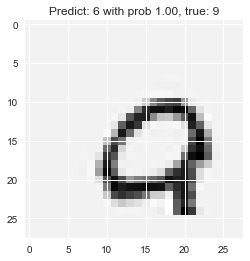

In [18]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

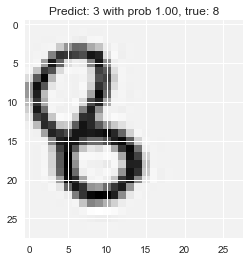

In [19]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

## Let's train on augmented data

In [32]:
# pipeline for train
ppl_shift = (mnistset.train.pipeline()
                          .load(src=src, fmt='ndarray')
                          .shift_flattened_pic()
                          .random_rotate(p=1, angle=(-10, 10), preserve_shape=True)
                          .random_scale(p=1, factor=(.8, 1.2))
                          .init_variable('acc_history', init_on_each_run=list)
                          .init_variable('current_acc', init_on_each_run=0)
                          .import_model('MyMnistModel', ppl)
                          .train_model('MyMnistModel', fetches='accuracy', feed_dict={'input_images': B('images'),
                                      'input_labels': B('labels'),
                                      'keep_prob':0.9},
                                       save_to=V('current_acc'))
                          .save_to_variable(V('acc_history'), V('current_acc'), mode='a'))

In [49]:
# pipeline for train
ppl_shift = (mnistset.train.pipeline()
                          .load(src=src, fmt='ndarray')
                          .shift_flattened_pic()
                          .random_rotate(p=1, angle=(-10, 10), preserve_shape=True)
                          .random_scale(p=1, factor=(.8, 1.2))
                          .init_variable('acc_history', init_on_each_run=list)
                          .import_model('MyMnistModel', ppl)
                          .train_model('MyMnistModel', fetches='accuracy', feed_dict={'input_images': B('images'),
                                      'input_labels': B('labels'),
                                      'keep_prob':0.9},
                          append_to = (V('acc_history'))))

In [50]:
for i in tqdm(range(1000)):
    ppl_shift.next_batch(100, n_epochs=None)
    ppl_test_shift.next_batch(100, n_epochs=None)

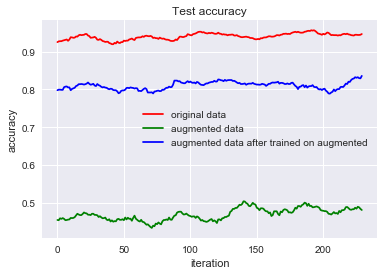

In [51]:
draw_stats([ppl_test.get_variable('test_acc_history')[-250:],  ppl_test_shift.get_variable('augmented_acc_history')[150:400],  ppl_test_shift.get_variable('augmented_acc_history')[-250:]], ['original data', 'augmented data', 'augmented data after trained on augmented'], \
           'Test accuracy')

In [52]:
ppl_results = (mnistset.test.pipeline() 
                            .load(src=src, fmt='ndarray')
                            .shift_flattened_pic() 
                            .random_rotate(p=1, angle=(-10, 10), preserve_shape=True) 
                            .random_scale(p=1, factor=(.8, 1.2)) 
                            .init_variable('y_predict', init_on_each_run=list)
                            .init_variable('y_true', init_on_each_run=list)
                            .init_variable('probs', init_on_each_run=list)
                            .init_variable('pics', init_on_each_run=list)
                            .import_model('MyMnistModel', ppl)
                            .predict_model('MyMnistModel', fetches=['predicted_labels', 'true_labels', 
                                                                    'predicted_prob', 'input_images'], 
                                                           feed_dict={'input_images': B('images'),
                                                                      'input_labels': B('labels'),
                                                                      'keep_prob':1.0},
                                                           append_to=[V('y_predict'), V('y_true'), V('probs'), V('pics')]))

In [53]:
ppl_results.next_batch(100, n_epochs=None)

In [54]:
y_predict = ppl_results.get_variable('y_predict')
y_true = ppl_results.get_variable('y_true')
probs = ppl_results.get_variable('probs')
pics = ppl_results.get_variable('pics')

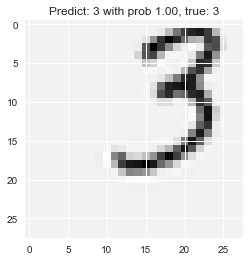

In [55]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

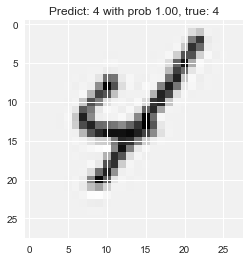

In [56]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

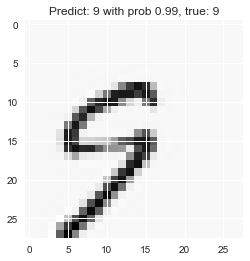

In [57]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

But we still have a space for improvement:

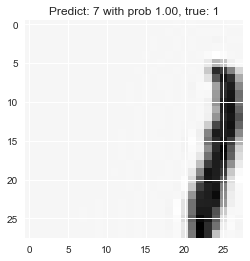

In [63]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

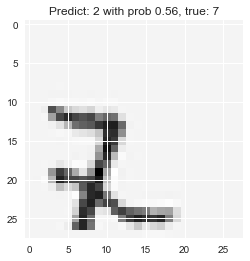

In [64]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

In [62]:
print('Test accuracy on the original data: %.2f %%' % (100.0*np.mean(ppl_test.get_variable('test_acc_history')[-250:])))
print('Test accuracy on the augmented data: %.2f %%' % (100.0*np.mean(ppl_test_shift.get_variable('augmented_acc_history')[150:400])))
print('Test accuracy on the augmented data after trained on the augmented data: %.2f %%' % (100.0*np.mean(ppl_test_shift.get_variable('augmented_acc_history')[-250:])))

Test accuracy on the original data: 94.04 %
Test accuracy on the augmented data: 46.86 %
Test accuracy on the augmented data after trained on the augmented data: 81.10 %
